# GMM

### Data preparation

First lets import all libraries that we will later use.

Also lets enable IPython's matplotlib inline mode to show plots.

In [112]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture

%matplotlib inline

Using sklearn make_blobs lets generate dataset for testing.

Here we define that we want 2 features, 300 samples and 3 classes with std 1 and also we pass 0 as random seed, so that data always generates same.

Finally lets plot generated points.

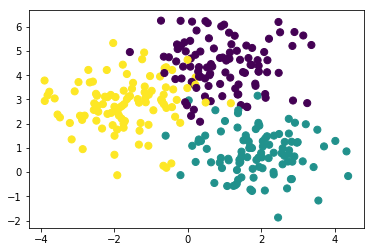

In [113]:
classesCount = 3
sampleCount = 300
x, y = make_blobs(n_samples=sampleCount, centers=classesCount, n_features=2, cluster_std=1, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y, s=50)

### Actual GMM implementation

##### Model parameter initialization

First step is to initialize parameters for EM algorithm.

As algorithm is very sensitive to initialization, so we use outputs of K-means.

* means we directly take from K-means output;
* covariance matrices we compute for each individual class, by first finding data values that belong to particular class and then calculating covariance matrix on them;
* weigths gets calculated by counting amount of data that belongs to particular class and dividing this number by total amount of samples

In [114]:
kmeans = KMeans(n_clusters=classesCount).fit(x)
meansArray = kmeans.cluster_centers_
labels = kmeans.labels_

sampleCount, featureCount = x.shape

covarianceMatrices = []
weights = []
for i in range(classesCount):
    classIndices = np.where(labels == i)[0]
    classValues = x[classIndices, :]

    covarianceMatrices.append(np.cov(classValues.T))
    weights.append(np.sum(labels == i) / sampleCount)

##### Expectation Maximization (EM) steps

After parameters are initiazized we can go to algorithm itself.

It consists of 3 main steps that are done iteratively until convergence condition is met.

* Step 1: Expectation

In this step for each sample we need to compute posterior probabilities of each class. It is done by muliplying weight and multivariate normal variable that is calculated using sample data and previously got mean and convariance matrix

* Step 2: Maximization

When all posterior probabilities are calculated we need to update model parameters for each cluster.
First need to update means. It is done by summing all posterior probabilities for particular cluster and then multiplying it by data.

Next we update convariance matrices. It is done by substracting means from each sample then multiplying it by transposed matrix and finally summing result. At the end cound covariance matrix is divided by sum of posterior probabilities.

Weights are updated by dividing sum of posterior probabilities by sum of all cluster posterior probabilities

* Step 3: Evaluation

In this step we compute log likelihood of our model and compare calculated likelihood to previous iterations likelihood and in case when it doesn't change that much we break out of loop and consider current model parameters as best.

In [115]:
convergence = False
t = 0
logLikelihood = []
while not convergence:
    # Step 1: Expectation - Compute posteriors of each cluster
    posteriors = np.zeros((sampleCount, classesCount))
    for n in range(sampleCount):
        for k in range(classesCount):
            posteriors[n, k] = weights[k] * multivariate_normal.pdf(x[n, :],
                mean=meansArray[k, :], cov=covarianceMatrices[k], allow_singular=False)
        posteriors[n, :] = posteriors[n, :] / np.sum(posteriors[n, :])

    # Step 2: Maximization - Update model parameters(means, covariance matrices and weights)
    sp = np.zeros(classesCount)
    for k in range(classesCount):
        # Update means
        sp[k] = np.sum(posteriors[:, k])
        posteriorIncreased = np.reshape(posteriors[:, k], (-1, 1))
        meansArray[k, :] = np.sum(posteriorIncreased * x, axis=0) / sp[k]

        # Update covariance matrices
        covarianceMatrices[k] = np.zeros((featureCount, featureCount))
        for n in range(sampleCount):
            zeroMeanXvector = (x[n, :] - meansArray[k, :])
            zeroMeanXmatrix = np.reshape(zeroMeanXvector, (-1, 1))
            covarianceMatrices[k] = covarianceMatrices[k] + np.dot(
                posteriors[n, k],
                np.dot(zeroMeanXmatrix, zeroMeanXmatrix.T))
        covarianceMatrices[k] = covarianceMatrices[k] / sp[k]

    # Update weights
    weights = sp / np.sum(sp)

    # Step 3: Evaluation - Compute log likelihood
    logLikelihood.append(0)
    for i in range(sampleCount):
        innerterm = 0
        for k in range(classesCount):
            innerterm = innerterm + weights[k] * multivariate_normal.pdf(x[i, :],
                mean=meansArray[k, :], cov=covarianceMatrices[k], allow_singular=False)
        logLikelihood[t] = logLikelihood[t] + np.log(innerterm)

    logLikelihood[t] = logLikelihood[t] / sampleCount

    if t > 0:
        convergence = (logLikelihood[t] - logLikelihood[t - 1]) < 0.000001
        logLikelihood[t] - logLikelihood[t - 1]
    print("Step: %d, logLikelihood: %f" % (t, logLikelihood[t]))
    t = t + 1

Step: 0, logLikelihood: -3.734337
Step: 1, logLikelihood: -3.733064
Step: 2, logLikelihood: -3.732571
Step: 3, logLikelihood: -3.732253
Step: 4, logLikelihood: -3.731992
Step: 5, logLikelihood: -3.731758
Step: 6, logLikelihood: -3.731543
Step: 7, logLikelihood: -3.731343
Step: 8, logLikelihood: -3.731157
Step: 9, logLikelihood: -3.730983
Step: 10, logLikelihood: -3.730822
Step: 11, logLikelihood: -3.730672
Step: 12, logLikelihood: -3.730533
Step: 13, logLikelihood: -3.730404
Step: 14, logLikelihood: -3.730285
Step: 15, logLikelihood: -3.730175
Step: 16, logLikelihood: -3.730073
Step: 17, logLikelihood: -3.729979
Step: 18, logLikelihood: -3.729893
Step: 19, logLikelihood: -3.729813
Step: 20, logLikelihood: -3.729740
Step: 21, logLikelihood: -3.729673
Step: 22, logLikelihood: -3.729611
Step: 23, logLikelihood: -3.729554
Step: 24, logLikelihood: -3.729501
Step: 25, logLikelihood: -3.729453
Step: 26, logLikelihood: -3.729409
Step: 27, logLikelihood: -3.729369
Step: 28, logLikelihood: -3.72

Now in order to get labels we need to compute posteriors for each class using previously found weights, means, covariances.

And after that, to determine class, for each sample we need to find posteriors that have highest probabilities and its index will be class we search for.

In end we plot points and their found class

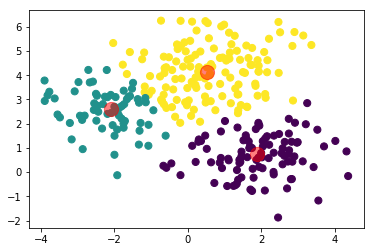

In [116]:
posteriors = np.zeros((sampleCount, classesCount))
for n in range(sampleCount):
    for k in range(classesCount):
        posteriors[n, k] = np.dot(weights[k],
                                  multivariate_normal.pdf(x[n, :], mean=meansArray[k, :],
                                                          cov=covarianceMatrices[k], allow_singular=False))
myLabels = posteriors.argmax(axis=1)

plt.scatter(x[:, 0], x[:, 1], c=myLabels, s=50)
plt.scatter(meansArray[:, 0], meansArray[:, 1], c='red', s=200, alpha=0.5)

Now lets compare precision of our GMM implementations and GMM built in Scikit-learn library.

First lets compute parameters using Scikit-learn GMM and then let's plot points and their class respectively.

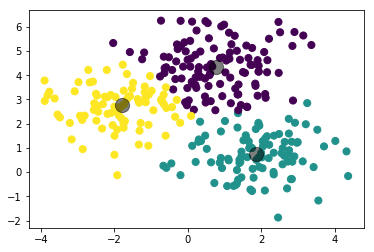

In [117]:
gmm = GaussianMixture(n_components=classesCount, random_state=0).fit(x)

sklearnLabels = gmm.predict(x)
sklearMeans = gmm.means_

plt.scatter(x[:, 0], x[:, 1], c=sklearnLabels, s=50)
plt.scatter(sklearMeans[:, 0], sklearMeans[:, 1], c='black', s=200, alpha=0.5)

Using Adjusted Rand index lets compare how similar GMM results are to groundtruth labels.

In order not to reinvent the wheel, lets use already created adjusted_rand_score from Scikit-learn library.

In [118]:
print("Sklearn gmm precision: %f" % adjusted_rand_score(y, sklearnLabels))
print("My gmm precision: %f" % adjusted_rand_score(y, myLabels))

Sklearn gmm precision: 0.765573
My gmm precision: 0.639762
